In [7]:
from functools import partial

import matplotlib.pyplot as plt

from superfv import EulerSolver, plot_1d_slice, plot_timeseries
from superfv.initial_conditions import entropy_wave

In [8]:
gamma = 5 / 3

In [9]:
configs = {
    "p3": dict(
        riemann_solver="hllc",
        p=3,
        flux_recipe=2,
    ),
    "ZS3": dict(
        riemann_solver="hllc",
        p=3,
        ZS=True,
        flux_recipe=2,
        lazy_primitives="none",
        PAD={"rho": (0, None), "P": (0, None)},
        SED=True,
    ),
    "MM3": dict(
        riemann_solver="hllc",
        p=3,
        flux_recipe=2,
        lazy_primitives="full",
        MOOD=True,
        cascade="muscl",
        MUSCL_limiter="moncen",
        max_MOOD_iters=1,
        blend=True,
        NAD=True,
        NAD_rtol=1e-2,
        NAD_atol=1e-8,
        SED=True,
    ),
}

In [10]:
N = 128

sims = {}
for name, config in configs.items():
    # print status
    print(f"Running N={N}, config={name}")

    # run solver
    sim = EulerSolver(
        ic=partial(entropy_wave, gamma=gamma), nx=N, gamma=gamma, **config
    )
    try:
        sim.run(n=1, reduce_CFL=True, muscl_hancock=config.get("MUSCL", False))
        sims[name] = sim
    except RuntimeError as e:
        print(f"  Failed: {e}")
        continue

Running N=128, config=p3
Step #1 @ t=3.12e-03 | dt=3.12e-03 | min(rho)=1.00e+00, min(P)=6.00e-01 | (ran in 0.01s)            
Running N=128, config=ZS3
Step #1 @ t=3.12e-03 | dt=3.12e-03 | min(rho)=1.00e+00, min(P)=6.00e-01 | (ran in 0.01s)            
Running N=128, config=MM3
Step #1 @ t=3.12e-03 | dt=3.12e-03 | min(rho)=1.00e+00, min(P)=6.00e-01 | (ran in 0.02s)            


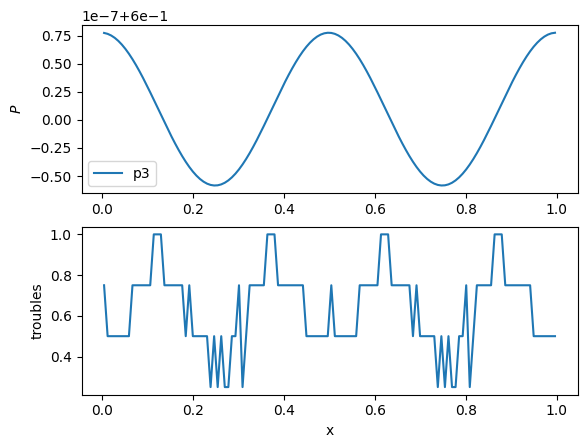

In [15]:
fig, axs = plt.subplots(2, 1)
axs[0].set_ylabel(r"$P$")
axs[1].set_ylabel("troubles")
axs[1].set_xlabel("x")

sim1 = sims["p3"]
sim2 = sims["MM3"]

plot_1d_slice(sim1, axs[0], "P", cell_averaged=True, label="p3")
# plot_1d_slice(sim2, axs[0], "P", cell_averaged=True, label="MM3")

# plot_1d_slice(
#     sim1,
#     axs[1],
#     "min",
#     theta=True,
#     visualization=False,
#     label="ZS3",
#     func=lambda x: 1 - x,
# )
plot_1d_slice(sim2, axs[1], "max", troubles=True, visualization=False, label="MM3")

axs[0].legend()

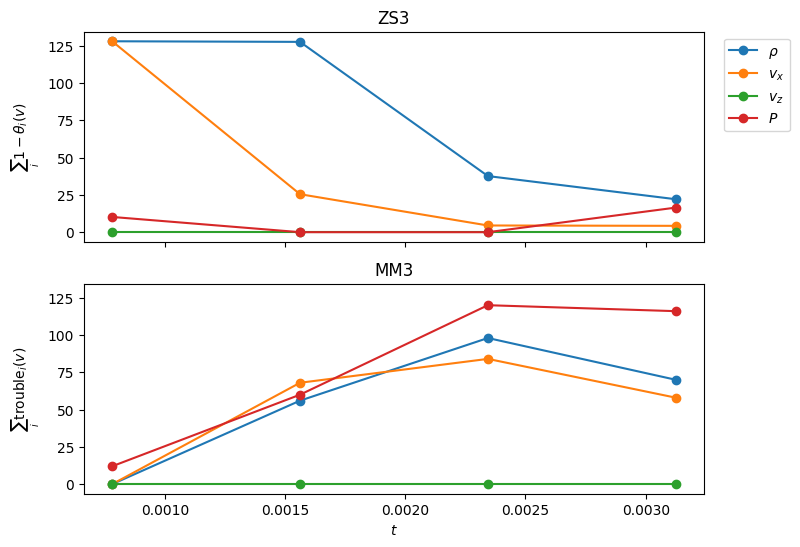

In [12]:
fig, axs = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(8, 6))
axs[0].set_title("ZS3")
axs[0].set_ylabel(r"$\sum_i 1-\theta_i(v) $")
axs[1].set_title("MM3")
axs[1].set_ylabel(r"$\sum_i \text{trouble}_i(v) $")
axs[1].set_xlabel(r"$t$")

sim1 = sims["ZS3"]
sim2 = sims["MM3"]

for var, label in [
    ("rho", r"$\rho$"),
    ("vx", r"$v_x$"),
    ("vz", r"$v_z$"),
    ("P", r"$P$"),
]:
    plot_timeseries(
        sim1,
        axs[0],
        var,
        label=label,
        one_minus_theta=True,
        visualization=False,
        marker="o",
    )
    plot_timeseries(
        sim2, axs[1], var, label=label, troubles=True, visualization=False, marker="o"
    )

axs[0].legend(bbox_to_anchor=(1.15, 1))